# Direct Step Method - Distance Calculated from Depth

## Example 1

A trapezoidal channel of base width 20 ft and side slopes $1\frac{1}{2}H: 1V$ is laid on a slope of 0.001 and carries a discharge of 1,000 cusecs. The channel terminates in a free overfall and it is desired to explore the "drawdown" to the overfall and the extent to which velocities are thereby increased. For this reason it is required to compute and plot the flow profile upstream from the overfall over the region where the velocity is at least 10 percent greater than at uniform flow. The Manning n = 0.025.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

## Channel Conditions

Flowrate $Q$:

In [2]:
Q = 1000

Slope $S_0$:

In [3]:
S0 = 0.001

Manning $n$:

In [4]:
n = 0.025

Gravitational acceleration $g$:

In [5]:
g = 32.174

### Area and wet perimeter

#### Area

In [6]:
def area(y):
    A = y * (20 + 1.5 * y)
    return A

#### Wet Perimeter

In [7]:
def perimeter(y):
    P = 20 + 2 * np.sqrt(3.25) * y
    return P

#### Hydraulic Radius

In [8]:
def radius(y):
    A = area(y)
    P = perimeter(y)
    R = A/P
    return R

#### Manning Equation (for solving y)

In [9]:
def Manning_y(y):
    A = area(y)
    R = radius(y)
    return (1.49 / n * A * R**(2/3) * np.sqrt(S0) - Q)

#### Velocity (for given y)

In [10]:
def vel_y(y):
    A = area(y)
    return Q/A

### Determine the normal depth $y_0$

Normal depth $y_0$:

In [11]:
sol = optimize.root_scalar(Manning_y, bracket=[1, 10], method='brentq')
y0 = sol.root
y0

6.548512918036519

Velocity in uniform flow $v_0$:

In [12]:
v0 = vel_y(y0)
v0

5.120464285562109

### Detremine the critical depth $y_c$

Note: at critical condition,
$$
v = \sqrt{g\frac{A}{B}}
$$
i.e.,
$$
Q^2 = g\frac{A^3}{B}
$$
where $B$ is the surface width.

In [13]:
def froot_yc(y):
    A = area(y)
    B = 20 + 3 * y
    return (g * A**3/B - Q**2)

In [14]:
sol2 = optimize.root_scalar(froot_yc, bracket=[1, 10], method='brentq')
yc = sol2.root
yc

3.854067234759995

## Computation of Direct Step Method

* Npt: number of points,
* y_Npt: depth at each points,
* v_Npt: velocity at each points,
* R_Npt: hydraulic radius at each points.

Compute the coordinates of the depths between $0.94 y_0$ and $y_c$:

In [15]:
Npt = 21
y_Npt = np.linspace(y0*0.94, yc, Npt)
y_Npt

array([6.15560214, 6.0405254 , 5.92544865, 5.81037191, 5.69529516,
       5.58021842, 5.46514167, 5.35006493, 5.23498818, 5.11991143,
       5.00483469, 4.88975794, 4.7746812 , 4.65960445, 4.54452771,
       4.42945096, 4.31437422, 4.19929747, 4.08422073, 3.96914398,
       3.85406723])

In [16]:
v_Npt = vel_y(y_Npt)
R_Npt = radius(y_Npt)

Chezy C:
$$
C = \frac{1.49}{n}R^{\frac{1}{6}}
$$

C2_Npt: $C^2$ at each points.

In [17]:
C2_Npt = (1.49 * radius(y_Npt)**(1/6) / n)**2

Define $dEdx = \Delta E/\Delta x$:
$$
dEdx = \frac{\Delta E}{\Delta x} = \left(S_0 - \frac{v^2}{C^2 R}\right)_m
$$
then
$$
\Delta x = \Delta E / dEdx
$$

In [18]:
E_Npt = y_Npt + v_Npt**2 / (2*g)
dx = np.zeros(Npt)
for i in range(1, Npt):
    dEdx_0 = S0 - v_Npt[i-1]**2 / (C2_Npt[i-1]*R_Npt[i-1])
    dEdx_1 = S0 - v_Npt[i]**2 / (C2_Npt[i]*R_Npt[i])
    dEdx = 0.5*(dEdx_0+dEdx_1)
    dE = E_Npt[i] - E_Npt[i-1]
    dx[i] = dE / dEdx

x_Npt: the coordinates of each y_Npt:

In [19]:
x_Npt = np.zeros(Npt)
for i in range(1, Npt):
    x_Npt[i] = x_Npt[i-1] + dx[i]

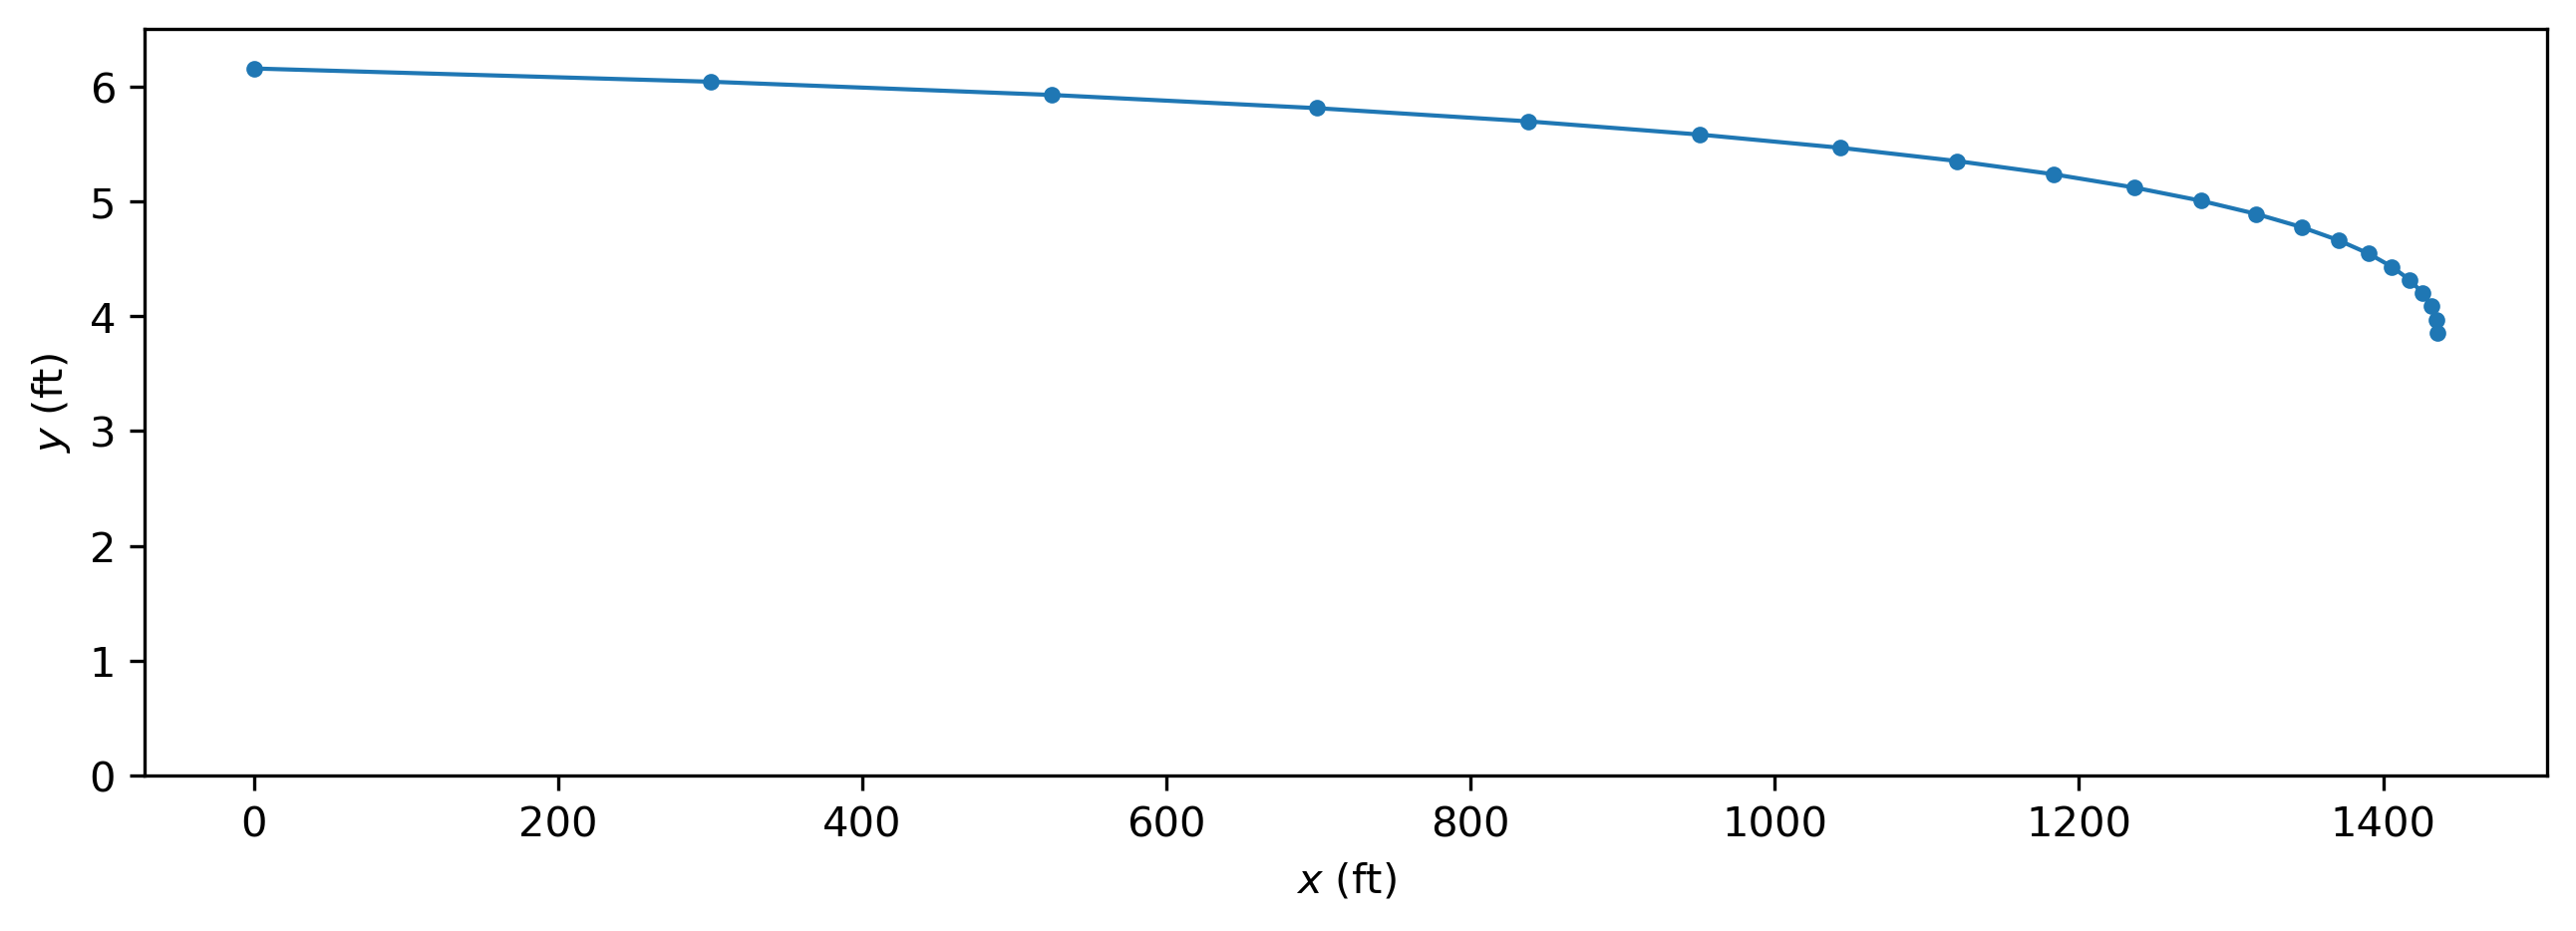

In [20]:
fig, ax = plt.subplots(figsize=(8.5, 3), layout='constrained', dpi=300)
ax.plot(x_Npt, y_Npt, linewidth=1, marker='.')
ax.set_xlabel('$x$ (ft)')
ax.set_ylabel('$y$ (ft)')
ax.set_ylim(0, 6.5)
plt.show()